In [2]:
from google.colab import drive
drive.mount('/content/drive')   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import tensorflow and other libraries

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

Use pandas to creat a dataframe

In [4]:
dataframe=pd.read_csv('/content/drive/My Drive/unconventional oil and gas/OG_Compliance.csv')

In [5]:
dataframe['Inspection year']=[i.split('/')[-1] for i in dataframe['INSPECTION_DATE']]

In [6]:
dataframe.head()

,OPERATOR,INSPECTION_ID,INSPECTION_DATE,INSPECTION_TYPE,API_PERMIT,FARM_NAME,UNCONVENTIONAL,SITE_ID,SITE_NAME,FACILITY_TYPE,...,ENFORCEMENT_ID,ENFORCEMENT_CODE_DESCRIPTION,DATE_EXECUTED,ENFORCEMENT_FINAL_DATE,ENFORCEMENT_FINAL_STATUS,PENALTY_FINAL_DATE,PENALTY_FINAL_STATUS_CODE_DESCRIPTION,PENALTY_AMOUNT,TOTAL_AMOUNT_COLLECTED,Inspection year
0,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,239235.0,CACP - Consent Assessment of Civil Penalty,10/20/2008,10/20/2008,Comply/Closed,10/20/2008,COMP - Completed,"$8,400","$8,400",2008
1,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,235597.0,NOV - Notice of Violation,07/07/2008,07/07/2008,Comply/Closed,NaN,NaN,NaN,NaN,2008
2,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,235597.0,NOV - Notice of Violation,07/07/2008,07/07/2008,Comply/Closed,NaN,NaN,NaN,NaN,2008
3,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,239235.0,CACP - Consent Assessment of Civil Penalty,10/20/2008,10/20/2008,Comply/Closed,10/20/2008,COMP - Completed,"$8,400","$8,400",2008
4,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,235597.0,NOV - Notice of Violation,07/07/2008,07/07/2008,Comply/Closed,NaN,NaN,NaN,NaN,2008


In [7]:
dataframe['Inspection year'].value_counts()

2018    19690
2019    19618
2017    16866
2016    15562
2015    13513
2012    13173
2013    12782
2014    11818
2011    11274
2010     6121
2009     2934
2008     1396
2007      205
2006       99
2005       45
2004       26
2003       24
2002       10
2001        4
2000        2
Name: Inspection year, dtype: int64

In [8]:
dataframe['enforcement']=[i.split('-')[0] for i in dataframe['ENFORCEMENT_CODE_DESCRIPTION'].astype(str)]

In [9]:
dataframe['enforcement'].astype(str)

0         CACP 
1          NOV 
2          NOV 
3         CACP 
4          NOV 
          ...  
145157      nan
145158      nan
145159      nan
145160      nan
145161      nan
Name: enforcement, Length: 145162, dtype: object

In [10]:
#清理数据 去除 ENFORCEMENT_CODE_DESCRIPTION 为空的行
dataframe=dataframe.dropna(subset=['ENFORCEMENT_CODE_DESCRIPTION'])
dataframe=dataframe[dataframe['VIOLATION_CODE'].map(len)>10]
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6586 entries, 0 to 144932
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   OPERATOR                               6586 non-null   object 
 1   INSPECTION_ID                          6586 non-null   int64  
 2   INSPECTION_DATE                        6586 non-null   object 
 3   INSPECTION_TYPE                        6586 non-null   object 
 4   API_PERMIT                             6586 non-null   object 
 5   FARM_NAME                              6586 non-null   object 
 6   UNCONVENTIONAL                         6586 non-null   object 
 7   SITE_ID                                6586 non-null   int64  
 8   SITE_NAME                              6586 non-null   object 
 9   FACILITY_TYPE                          6586 non-null   object 
 10  INSPECTION_CATEGORY                    6586 non-null   object 
 11  RE

In [11]:
# 查看分类的个数
dataframe['ENFORCEMENT_CODE_DESCRIPTION'].value_counts()

NOV - Notice of Violation                     4999
CACP - Consent Assessment of Civil Penalty    1279
COA - Consent Order and Agreement              226
ADORD - Administrative Order                    45
CMPOR - Compliance Order                        20
CESOR - Cessation Order                         10
EHBO - Environmental Hearing Board Order         4
FLNOV - Field Notice of Violation                2
CPA - Civil Penalty Assessment                   1
Name: ENFORCEMENT_CODE_DESCRIPTION, dtype: int64

In [12]:
# 重新梳理分类
# 第一个分类：违规通知 NOV FLNOV 0
# 第二个分类： 民事处罚的同意评估 CACP CPA 1
# 第三个分类： 同意令及协议 COA 2
# 第四个分类： [管理] 行政命令 ADORD 3
# 第五个分类： 守法令 纠正命令 CMPOR 4
# 第六个分类： 终止令 CESOR 5
# 第七个分类： 环境聆讯委员会令 EHBO 6
name=["NOV ","FLNOV ","CACP ","CPA ","COA ","ADORD ","CMPOR ","CESOR ","EHBO "]
title=[0,0,1,1,2,3,4,5,6]
dataframe['label']=dataframe['enforcement'].replace(name,title)

In [13]:
dataframe['label'].value_counts()

0    5001
1    1280
2     226
3      45
4      20
5      10
6       4
Name: label, dtype: int64

In [14]:
# 利用label 形成掩码数组
mask_array=dataframe['label'].values
mask_array.shape

(6586,)

In [15]:
# 创建不同label_severity,label_s的掩码
import numpy.ma as ma

masks_0=ma.masked_not_equal(mask_array,0).mask #只包含label=0
masks_1=ma.masked_not_equal(mask_array,1).mask #只包含label=1
masks_2=ma.masked_not_equal(mask_array,2).mask #只包含label=2
masks_3=ma.masked_not_equal(mask_array,3).mask #只包含label=3
masks_4=ma.masked_not_equal(mask_array,4).mask #只包含label=4
masks_5=ma.masked_not_equal(mask_array,5).mask #只包含label=5
masks_6=ma.masked_not_equal(mask_array,6).mask #只包含label=6

三层模型对应三个不同数据库。

In [16]:
# 第三个数据库 从违规情况、严重程度、类型 作出 行政手段建议
dataframe_enf=dataframe[['OPERATOR','SITE_ID','COUNTY','VIOLATION_CODE','INSPECTION_COMMENT','VIOLATION_TYPE','INSPECTION_RESULT_DESCRIPTION','Inspection year','label']]
dataframe_enf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6586 entries, 0 to 144932
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   OPERATOR                       6586 non-null   object
 1   SITE_ID                        6586 non-null   int64 
 2   COUNTY                         6586 non-null   object
 3   VIOLATION_CODE                 6586 non-null   object
 4   INSPECTION_COMMENT             4309 non-null   object
 5   VIOLATION_TYPE                 6586 non-null   object
 6   INSPECTION_RESULT_DESCRIPTION  6586 non-null   object
 7   Inspection year                6586 non-null   object
 8   label                          6586 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 514.5+ KB


# 1 第一个数据库

In [17]:
#导入必要的库
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

# 创建Violation dataset，词数1288

In [18]:
violationcode=dataframe_enf['VIOLATION_CODE'].values

In [19]:
violationcode

array(['301CSL - Stream discharge of IW, includes drill cuttings, oil, brine and/or silt',
       '78.56PITCNST - Impoundment not structurally sound, impermeable, 3rd party protected, greater than 20" of seasonal high ground water table',
       '301CSL - Stream discharge of IW, includes drill cuttings, oil, brine and/or silt',
       ...,
       '78a56(a) - TEMPORARY STORAGE - Operator failed to contain regulated substances and wastes used at or generated at a well site in a tank, series of tanks or other storage structures approved by the Department.',
       'CSL 402(b) - POTENTIAL POLLUTION - Conducting an activity regulated by a permit issued pursuant to Section 402 of The Clean Streams Law to prevent the potential of pollution to waters of the Commonwealth without a permit or contrary to a permit issued under that authority by the Department.',
       '78a66(b)1 - REPORTING AND REMEDIATING SPILLS AND RELEASES – Reporting releases – Operator or other responsible party failed to re

In [20]:
#将 inspection comment 进行preprocessing 处理，表示为sentence_seq
def pre_sentence(features):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(features)
  tokenizer_config=tokenizer.get_config()
  #保存字典以便后面画图
  word_counts=json.loads(tokenizer_config['word_counts'])
  index_word=json.loads(tokenizer_config['index_word'])
  word_index=json.loads(tokenizer_config['word_index'])

  #map the sentences to tokens
  sentence_seq=tokenizer.texts_to_sequences(features)

  return word_counts,index_word,word_index,sentence_seq

In [21]:
enf_word,enf_iw,enf_wi,enf_seq=pre_sentence(violationcode)

In [22]:
len(enf_word)

1241

In [23]:
#确定维度最高为128维
enf_ins=pad_sequences(enf_seq,padding='post',maxlen=128)

In [24]:
enf_ins.shape

(6586, 128)

In [25]:
code_np=np.array(enf_ins)
code_np.shape

(6586, 128)

# Inspection comment dataset

In [26]:
inscode=dataframe_enf['INSPECTION_COMMENT'].values.astype(str)

In [27]:
ins_word,ins_iw,ins_wi,ins_seq=pre_sentence(inscode)

In [28]:
len(ins_word)

7436

In [29]:
ins_pd=pad_sequences(ins_seq,padding='post',maxlen=128)
ins_np=np.array(ins_pd)
ins_np.shape

(6586, 128)

# 创建 severity numpy



In [30]:
#构建label的dataset
sev_np=dataframe_enf['INSPECTION_RESULT_DESCRIPTION'].values

In [31]:
#构建severity vocab
sev_vocab=dataframe_enf['INSPECTION_RESULT_DESCRIPTION'].value_counts()
sev_vocab=sev_vocab.index

In [32]:
layersev=preprocessing.StringLookup()
layersev.adapt(sev_np)

In [33]:
layersev.get_vocabulary()

['[UNK]',
 'Violation(s) Noted',
 "Outstanding Violations - Viols Req'd",
 'Viol(s) Noted &  Immediately Corrected',
 'Violation(s) & Outstanding Violations',
 'Recurring Violations',
 'Violation(s) & Recurring Violations']

In [34]:
sev_np=layersev(sev_np)
sev_np=np.array(sev_np)
sev_np=sev_np.reshape(-1,1)
sev_np.shape

(6586, 1)

# 创建couty dataset 大小为（100337，）

outputmode=tf-idf

In [35]:
#构建一个只包含category attribute的dataframe
county=dataframe_enf['COUNTY'].values
county

array(['Fayette', 'Fayette', 'Fayette', ..., 'Clinton', 'Clinton',
       'Clinton'], dtype=object)

In [36]:
# 构建attribute dataset
county_vocab=dataframe_enf["COUNTY"].value_counts()
county_vocab=county_vocab.index
county_vocab

Index(['Bradford', 'Susquehanna', 'Washington', 'Tioga', 'Lycoming', 'Greene',
       'Westmoreland', 'Potter', 'Somerset', 'Wyoming', 'Fayette', 'Armstrong',
       'Sullivan', 'Jefferson', 'Allegheny', 'Elk', 'Butler', 'Clearfield',
       'McKean', 'Clarion', 'Clinton', 'Cameron', 'Centre', 'Lawrence',
       'Forest', 'Beaver', 'Indiana', 'Mercer', 'Blair', 'Venango', 'Erie',
       'Warren', 'Cambria', 'Wayne', 'Crawford', 'Huntingdon', 'Bedford'],
      dtype='object')

In [37]:
len(county_vocab)

37

In [38]:
layer1=preprocessing.StringLookup()
layer1.adapt(county)

In [39]:
layer1.get_vocabulary()

['[UNK]',
 'Bradford',
 'Susquehanna',
 'Washington',
 'Tioga',
 'Lycoming',
 'Greene',
 'Westmoreland',
 'Potter',
 'Somerset',
 'Wyoming',
 'Fayette',
 'Armstrong',
 'Sullivan',
 'Jefferson',
 'Allegheny',
 'Elk',
 'Clearfield',
 'Butler',
 'McKean',
 'Clarion',
 'Clinton',
 'Cameron',
 'Centre',
 'Lawrence',
 'Forest',
 'Beaver',
 'Indiana',
 'Mercer',
 'Blair',
 'Venango',
 'Warren',
 'Erie',
 'Wayne',
 'Crawford',
 'Cambria',
 'Huntingdon',
 'Bedford']

In [40]:
county_cate=layer1(county)

In [41]:
county_np=np.array(county_cate)
county_np=county_np.reshape(-1,1)
county_np.shape

(6586, 1)

# 创建SITE_ID dataset 使用cate embedding 的形式




In [42]:
site_id=dataframe_enf['SITE_ID'].values
site_id[:3]

array([702939, 702939, 702939])

In [43]:
layer_site=preprocessing.IntegerLookup()
layer_site.adapt(site_id)
layer_site.get_vocabulary()

[-1,
 715902,
 714919,
 740459,
 712876,
 722948,
 785127,
 725305,
 698294,
 722723,
 722954,
 739302,
 722624,
 693064,
 838745,
 724559,
 715541,
 737168,
 729037,
 691948,
 726165,
 814645,
 743191,
 755544,
 746724,
 735791,
 726414,
 724852,
 815869,
 763105,
 735592,
 788808,
 781204,
 774653,
 753289,
 702197,
 783869,
 700581,
 822232,
 786108,
 760464,
 756252,
 745721,
 736566,
 725270,
 724022,
 712032,
 702939,
 695186,
 787638,
 787453,
 735270,
 728585,
 728307,
 713045,
 784537,
 761919,
 761246,
 736975,
 736560,
 734551,
 731759,
 713221,
 694950,
 784186,
 784003,
 783514,
 767452,
 766161,
 725265,
 721817,
 706127,
 777109,
 772717,
 759921,
 748803,
 747219,
 740885,
 732956,
 728569,
 698061,
 621835,
 820926,
 815197,
 810535,
 741163,
 739790,
 734164,
 730037,
 727361,
 724633,
 810846,
 780095,
 761530,
 750663,
 745363,
 742564,
 742198,
 737163,
 736319,
 733398,
 731763,
 730549,
 729528,
 726974,
 724018,
 716461,
 714976,
 705132,
 699667,
 696376,
 5016

In [44]:
len(layer_site.get_vocabulary())

1300

In [45]:
siteid_cat=layer_site(site_id)
siteid_np=np.array(siteid_cat)
siteid_np=siteid_np.reshape(-1,1)
siteid_np

array([[ 47],
       [ 47],
       [ 47],
       ...,
       [271],
       [271],
       [271]])

# 创建 Operator dataset categorical embedding

In [46]:
operator=dataframe_enf['OPERATOR'].values
operator

array(['AB RESOURCES PA LLC', 'AB RESOURCES PA LLC',
       'AB RESOURCES PA LLC', ..., 'XTO ENERGY INC', 'XTO ENERGY INC',
       'XTO ENERGY INC'], dtype=object)

In [47]:
layer3=preprocessing.StringLookup()  
layer3.adapt(operator)
layer3.get_vocabulary()

['[UNK]',
 'RANGE RESOURCES APPALACHIA LLC',
 'CHESAPEAKE APPALACHIA LLC',
 'EQT PROD CO',
 'CABOT OIL & GAS CORP',
 'CHIEF OIL & GAS LLC',
 'REPSOL OIL & GAS USA LLC',
 'SENECA RESOURCES CO LLC',
 'EAST RESOURCES INC',
 'RICE DRILLING B LLC',
 'XTO ENERGY INC',
 'EOG RESOURCES INC',
 'PA GEN ENERGY CO LLC',
 'WEST TEXAS OPERATING CO LLC D/B/A XTREME ENERGY CO',
 'CHEVRON APPALACHIA LLC',
 'ATLAS RESOURCES LLC',
 'XPR RESOURCES LLC',
 'CNX GAS CO LLC',
 'SWN PROD CO LLC',
 'SWEPI LP',
 'DIVERSIFIED OIL & GAS LLC',
 'SOUTHWESTERN ENERGY PROD CO',
 'ULTRA RESOURCES INC',
 'ANADARKO E&P ONSHORE LLC',
 'INFLECTION ENERGY (PA) LLC',
 'JKLM ENERGY LLC',
 'HILCORP ENERGY CO',
 'ENERGY CORP OF AMER',
 'CARRIZO (MARCELLUS) LLC',
 'EXCO RESOURCES PA LLC',
 'J W OPERATING CO',
 'CITRUS ENERGY CORP',
 'SNYDER BROS INC',
 'EXCO RESOURCES PA INC',
 'ROCKDALE MARCELLUS LLC',
 'VANTAGE ENERGY APPALACHIA II LLC',
 'MDS ENERGY LTD',
 'REX ENERGY OPERATING CORP',
 'TRIANA ENERGY LLC',
 'MIEKA LLC',
 'ALP

In [48]:
len(layer3.get_vocabulary())

106

In [49]:
operator_cat=layer3(operator)
operator_np=np.array(operator_cat)
operator_np=operator_np.reshape(-1,1)
operator_np

array([[53],
       [53],
       [53],
       ...,
       [10],
       [10],
       [10]])

# 创建year category embedding 

In [50]:
year=dataframe_enf['Inspection year'].values.astype(int)
year

array([2008, 2008, 2008, ..., 2019, 2019, 2019])

In [51]:
layer4=preprocessing.IntegerLookup()
layer4.adapt(year)
layer4.get_vocabulary()

[-1,
 2010,
 2009,
 2018,
 2011,
 2012,
 2013,
 2019,
 2017,
 2016,
 2014,
 2015,
 2008,
 2007,
 2006,
 2005,
 2004,
 2001]

In [52]:
len(layer4.get_vocabulary())

18

In [53]:
year_cat=layer4(year)
year_np=np.array(year_cat)
year_np=year_np.reshape(-1,1)
year_np

array([[12],
       [12],
       [12],
       ...,
       [ 7],
       [ 7],
       [ 7]])

# Type numpy

In [54]:
typev=dataframe_enf['VIOLATION_TYPE'].values

In [55]:
layer5=preprocessing.StringLookup()  
layer5.adapt(typev)
layer5.get_vocabulary()

['[UNK]', 'Environmental Health & Safety', 'Administrative']

In [56]:
len(layer5.get_vocabulary())

3

In [57]:
typev_cat=layer5(typev)
type_np=np.array(typev_cat)
type_np=type_np.reshape(-1,1)
type_np

array([[1],
       [2],
       [1],
       ...,
       [1],
       [1],
       [1]])

# 区分训练集、验证集、测试集

In [58]:
label=dataframe_enf['label'].values
label_np=pd.get_dummies(label).values
label_np.shape

(6586, 7)

In [59]:
#获取训练集与测试集 test
ins_train,ins_test,code_train,code_test,county_train,county_test,siteid_train,siteid_test,operator_train,operator_test,year_train,year_test,label_train,label_test,sev_train,sev_test,type_train,type_test,labelm_train,labelm_test=train_test_split(ins_np,code_np,county_np,siteid_np,operator_np,year_np,label_np,sev_np,type_np,label,test_size=0.3,random_state=50)

In [60]:
label_train

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [61]:
#查看数据条例
print(year_train.shape,"year_train")
print(year_test.shape,"year_test")

(4610, 1) year_train
(1976, 1) year_test


In [63]:
# 创建treatment7个集合
#0
year_0=ma.array(year_np,mask=masks_0).compressed()
code_0=ma.array(code_np,mask=masks_0.repeat(128)).compressed()
code_0=np.reshape(code_0,(-1,128))
ins_0=ma.array(ins_np,mask=masks_0.repeat(128)).compressed()
ins_0=np.reshape(ins_0,(-1,128))
county_0=ma.array(county_np,mask=masks_0).compressed()
siteid_0=ma.array(siteid_np,mask=masks_0).compressed()
operator_0=ma.array(operator_np,mask=masks_0).compressed()
type_0=ma.array(type_np,mask=masks_0).compressed()
sev_0=ma.array(sev_np,mask=masks_0).compressed()
label_0=ma.array(label_np,mask=masks_0.repeat(7)).compressed()
label_0=np.reshape(label_0,(-1,7))

#1
year_1=ma.array(year_np,mask=masks_1).compressed()
code_1=ma.array(code_np,mask=masks_1.repeat(128)).compressed()
code_1=np.reshape(code_1,(-1,128))
ins_1=ma.array(ins_np,mask=masks_1.repeat(128)).compressed()
ins_1=np.reshape(ins_1,(-1,128))
county_1=ma.array(county_np,mask=masks_1).compressed()
siteid_1=ma.array(siteid_np,mask=masks_1).compressed()
operator_1=ma.array(operator_np,mask=masks_1).compressed()
type_1=ma.array(type_np,mask=masks_1).compressed()
sev_1=ma.array(sev_np,mask=masks_1).compressed()
label_1=ma.array(label_np,mask=masks_1.repeat(7)).compressed()
label_1=np.reshape(label_1,(-1,7))


#2
year_2=ma.array(year_np,mask=masks_2).compressed()
code_2=ma.array(code_np,mask=masks_2.repeat(128)).compressed()
code_2=np.reshape(code_2,(-1,128))
ins_2=ma.array(ins_np,mask=masks_2.repeat(128)).compressed()
ins_2=np.reshape(ins_2,(-1,128))
county_2=ma.array(county_np,mask=masks_2).compressed()
siteid_2=ma.array(siteid_np,mask=masks_2).compressed()
operator_2=ma.array(operator_np,mask=masks_2).compressed()
type_2=ma.array(type_np,mask=masks_2).compressed()
sev_2=ma.array(sev_np,mask=masks_2).compressed()
label_2=ma.array(label_np,mask=masks_2.repeat(7)).compressed()
label_2=np.reshape(label_2,(-1,7))


#3
year_3=ma.array(year_np,mask=masks_3).compressed()
code_3=ma.array(code_np,mask=masks_3.repeat(128)).compressed()
code_3=np.reshape(code_3,(-1,128))
ins_3=ma.array(ins_np,mask=masks_3.repeat(128)).compressed()
ins_3=np.reshape(ins_3,(-1,128))
county_3=ma.array(county_np,mask=masks_3).compressed()
siteid_3=ma.array(siteid_np,mask=masks_3).compressed()
operator_3=ma.array(operator_np,mask=masks_3).compressed()
type_3=ma.array(type_np,mask=masks_3).compressed()
sev_3=ma.array(sev_np,mask=masks_3).compressed()
label_3=ma.array(label_np,mask=masks_3.repeat(7)).compressed()
label_3=np.reshape(label_3,(-1,7))


#4
year_4=ma.array(year_np,mask=masks_4).compressed()
code_4=ma.array(code_np,mask=masks_4.repeat(128)).compressed()
code_4=np.reshape(code_4,(-1,128))
ins_4=ma.array(ins_np,mask=masks_4.repeat(128)).compressed()
ins_4=np.reshape(ins_4,(-1,128))
county_4=ma.array(county_np,mask=masks_4).compressed()
siteid_4=ma.array(siteid_np,mask=masks_4).compressed()
operator_4=ma.array(operator_np,mask=masks_4).compressed()
type_4=ma.array(type_np,mask=masks_4).compressed()
sev_4=ma.array(sev_np,mask=masks_4).compressed()
label_4=ma.array(label_np,mask=masks_4.repeat(7)).compressed()
label_4=np.reshape(label_4,(-1,7))


#5
year_5=ma.array(year_np,mask=masks_5).compressed()
code_5=ma.array(code_np,mask=masks_5.repeat(128)).compressed()
code_5=np.reshape(code_5,(-1,128))
ins_5=ma.array(ins_np,mask=masks_5.repeat(128)).compressed()
ins_5=np.reshape(ins_5,(-1,128))
county_5=ma.array(county_np,mask=masks_5).compressed()
siteid_5=ma.array(siteid_np,mask=masks_5).compressed()
operator_5=ma.array(operator_np,mask=masks_5).compressed()
type_5=ma.array(type_np,mask=masks_5).compressed()
sev_5=ma.array(sev_np,mask=masks_5).compressed()
label_5=ma.array(label_np,mask=masks_5.repeat(7)).compressed()
label_5=np.reshape(label_5,(-1,7))


#6
year_6=ma.array(year_np,mask=masks_6).compressed()
code_6=ma.array(code_np,mask=masks_6.repeat(128)).compressed()
code_6=np.reshape(code_6,(-1,128))
ins_6=ma.array(ins_np,mask=masks_6.repeat(128)).compressed()
ins_6=np.reshape(ins_6,(-1,128))
county_6=ma.array(county_np,mask=masks_6).compressed()
siteid_6=ma.array(siteid_np,mask=masks_6).compressed()
operator_6=ma.array(operator_np,mask=masks_6).compressed()
type_6=ma.array(type_np,mask=masks_6).compressed()
sev_6=ma.array(sev_np,mask=masks_6).compressed()
label_6=ma.array(label_np,mask=masks_6.repeat(7)).compressed()
label_6=np.reshape(label_6,(-1,7))

In [64]:
#over-sampling 从集合3开始
#3
year_3=np.repeat(year_3,4)
code_3=np.repeat(code_3,4,axis=0)
ins_3=np.repeat(ins_3,4,axis=0)
county_3=np.repeat(county_3,4)
siteid_3=np.repeat(siteid_3,4)
operator_3=np.repeat(operator_3,4)
type_3=np.repeat(type_3,4)
sev_3=np.repeat(sev_3,4)
label_3=np.repeat(label_3,4,axis=0)

#4
year_4=np.repeat(year_4,5)
code_4=np.repeat(code_4,5,axis=0)
ins_4=np.repeat(ins_4,5,axis=0)
county_4=np.repeat(county_4,5)
siteid_4=np.repeat(siteid_4,5)
operator_4=np.repeat(operator_4,5)
type_4=np.repeat(type_4,5)
sev_4=np.repeat(sev_4,5)
label_4=np.repeat(label_4,5,axis=0)

#5
year_5=np.repeat(year_5,5)
code_5=np.repeat(code_5,5,axis=0)
ins_5=np.repeat(ins_5,5,axis=0)
county_5=np.repeat(county_5,5)
siteid_5=np.repeat(siteid_5,5)
operator_5=np.repeat(operator_5,5)
type_5=np.repeat(type_5,5)
sev_5=np.repeat(sev_5,5)
label_5=np.repeat(label_5,5,axis=0)

#6
year_6=np.repeat(year_6,5)
code_6=np.repeat(code_6,5,axis=0)
ins_6=np.repeat(ins_6,5,axis=0)
county_6=np.repeat(county_6,5)
siteid_6=np.repeat(siteid_6,5)
operator_6=np.repeat(operator_6,5)
type_6=np.repeat(type_6,5)
sev_6=np.repeat(sev_6,5)
label_6=np.repeat(label_6,5,axis=0)

In [65]:
print('2',year_2.shape)
print('3',year_3.shape)
print('4',year_4.shape)
print('5',year_5.shape)
print('6',year_6.shape)

2 (226,)
3 (180,)
4 (100,)
5 (50,)
6 (20,)


In [66]:
#打乱顺序

#3
per_3=np.random.permutation(180)
year_3=year_3[per_3]
code_3=code_3[per_3]
ins_3=ins_3[per_3]
county_3=county_3[per_3]
siteid_3=siteid_3[per_3]
operator_3=operator_3[per_3]
type_3=type_3[per_3]
sev_3=sev_3[per_3]

#4
per_4=np.random.permutation(100)
year_4=year_4[per_4]
code_4=code_4[per_4]
ins_4=ins_4[per_4]
county_4=county_4[per_4]
siteid_4=siteid_4[per_4]
operator_4=operator_4[per_4]
type_4=type_4[per_4]
sev_4=sev_4[per_4]

#5
per_5=np.random.permutation(50)
year_5=year_2[per_5]
code_5=code_2[per_5]
ins_5=ins_2[per_5]
county_5=county_2[per_5]
siteid_5=siteid_2[per_5]
operator_5=operator_2[per_5]
type_5=type_2[per_5]
sev_5=sev_2[per_5]

#6
per_6=np.random.permutation(20)
year_6=year_6[per_6]
code_6=code_6[per_6]
ins_6=ins_6[per_6]
county_6=county_6[per_6]
siteid_6=siteid_6[per_6]
operator_6=operator_6[per_6]
type_6=type_6[per_6]
sev_6=sev_6[per_6]

In [67]:
#创建机器学习的标签集
labelm_0=np.repeat([0],5001)
labelm_1=np.repeat([1],1280)
labelm_2=np.repeat([2],226)
labelm_3=np.repeat([3],180)
labelm_4=np.repeat([4],100)
labelm_5=np.repeat([5],50)
labelm_6=np.repeat([6],20)

labelm_all=np.concatenate((labelm_0,labelm_1,labelm_2,labelm_3,labelm_4,labelm_5,labelm_6),axis=0)
print(labelm_all.shape)

(6857,)


In [68]:
#合并
year_all=np.concatenate((year_0,year_1,year_2,year_3,year_4,year_5,year_6),axis=0)
code_all=np.concatenate((code_0,code_1,code_2,code_3,code_4,code_5,code_6),axis=0)
ins_all=np.concatenate((ins_0,ins_1,ins_2,ins_3,ins_4,ins_5,ins_6),axis=0)
county_all=np.concatenate((county_0,county_1,county_2,county_3,county_4,county_5,county_6),axis=0)
siteid_all=np.concatenate((siteid_0,siteid_1,siteid_2,siteid_3,siteid_4,siteid_5,siteid_6),axis=0)
operator_all=np.concatenate((operator_0,operator_1,operator_2,operator_3,operator_4,operator_5,operator_6),axis=0)
type_all=np.concatenate((type_0,type_1,type_2,type_3,type_4,type_5,type_6),axis=0)
sev_all=np.concatenate((sev_0,sev_1,sev_2,sev_3,sev_4,sev_5,sev_6),axis=0)
label_all=np.concatenate((label_0,label_1,label_2,label_3,label_4,label_5,label_6),axis=0)


#总的train_test
ins_train,ins_test,code_train,code_test,county_train,county_test,siteid_train,siteid_test,operator_train,operator_test,year_train,year_test,label_train,label_test,sev_train,sev_test,type_train,type_test,labelm_train,labelm_test=train_test_split(ins_all,code_all,county_all,siteid_all,operator_all,year_all,label_all,sev_all,type_all,labelm_all,test_size=0.3,random_state=50)

In [69]:
print("ins train",ins_train.shape)

ins train (4799, 128)


In [ ]:
print("code test",code_test.shape)

In [71]:
print('code train',code_train.shape)

code train (4799, 128)


In [72]:
#计算训练标签
import collections
collections.Counter(labelm_train)

Counter({0: 3498, 1: 907, 2: 166, 3: 117, 4: 67, 5: 29, 6: 15})

In [73]:
collections.Counter(labelm_test)

Counter({0: 1503, 1: 373, 2: 60, 3: 63, 4: 33, 5: 21, 6: 5})

最终，0：5001
1：1280
2：226
3：180
4：100
5：50
6：20

# GRU

In [85]:
from tensorflow.keras.layers import Embedding,Attention,GRU,Concatenate,Dense,Input,LSTM
from tensorflow.keras import Model

In [75]:
a=np.random.rand(4799,1,7)

In [76]:
a.shape

(4799, 1, 7)

In [77]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))
input_t=Input(shape=(1,))
input_sev=Input(shape=(1,))

e_code=Embedding(1242,128,name='violation_code')(input_code) #(batch,128,128)
e_ins=Embedding(7437,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(19,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(107,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1301,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(38,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_t=Embedding(4,128,name='type')(input_t)
e_t=Dense(128,activation='relu')(e_t)
e_t=Dense(128,activation='relu')(e_t)

e_sev=Embedding(8,128,name='severity')(input_sev)
e_sev=Dense(128,activation='relu')(e_sev)
e_sev=Dense(128,activation='relu')(e_sev)


e_code=GRU(128,activation='tanh')(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,1,128)

e_ins=GRU(128,activation='tanh')(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_t,e_sev]) #(batch,7,128)
contextv,attention_score=Attention()([e_o,concate],return_attention_scores=True)

output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(7,activation='softmax',name='output_treatment')(output1) #(batch,1,7)
output1=tf.reshape(output1,(-1,7)) #(batch,7)


model=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c,input_t,input_sev],
            outputs=[output1,attention_score])

In [78]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [79]:
#确定 metrics
m1=tf.keras.metrics.Accuracy()
m2=tf.keras.metrics.CategoricalAccuracy()
m3=tf.keras.metrics.Precision()
m4=tf.keras.metrics.Recall()

In [80]:
#使用earlystopping 
early_stopping=tf.keras.callbacks.EarlyStopping(patience=10)

In [81]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_gru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [82]:
#确定优化器、损失函数、准则
model.compile(optimizer='adam',loss=['categorical_crossentropy','binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[[m1,m2,m3,m4],[]]) #2个输出

In [ ]:
history=model.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train,type_train,sev_train],y=[label_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.6098 - tf.reshape_loss: 1.6098 - attention_loss: 1.0541 - tf.reshape_accuracy: 0.0000e+00 - tf.reshape_categorical_accuracy: 0.6893 - tf.reshape_precision: 0.7174 - tf.reshape_recall: 0.0688
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_gru/cp-01.ckpt
17/17 [==============================] - 32s 1s/step - loss: 1.6098 - tf.reshape_loss: 1.6098 - attention_loss: 1.0541 - tf.reshape_accuracy: 0.0000e+00 - tf.reshape_categorical_accuracy: 0.6893 - tf.reshape_precision: 0.7174 - tf.reshape_recall: 0.0688 - val_loss: 1.1003 - val_tf.reshape_loss: 1.1003 - val_attention_loss: 1.0723 - val_tf.reshape_accuracy: 0.0000e+00 - val_tf.reshape_categorical_accuracy: 0.7146 - val_tf.reshape_precision: 0.7146 - val_tf.reshape_recall: 0.7146
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.8867 - tf.reshape_loss: 0.8867 - attention_loss: 1.0614 - tf.reshape_a

In [83]:
model.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_gru/cp-09.ckpt')

In [ ]:
#制造虚拟目标
b=np.random.rand(2461,1,7)

In [ ]:
#在测试集上测试效果
model.evaluate(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test],
               y=[label_test,b])

62/62 [==============================] - 7s 58ms/step - loss: 0.6643 - tf.reshape_loss: 0.6643 - attention_loss: 1.0781 - tf.reshape_accuracy: 0.0000e+00 - tf.reshape_categorical_accuracy: 0.7535 - tf.reshape_precision_1: 0.7633 - tf.reshape_recall: 0.7394


[0.664348304271698,
 0.664348304271698,
 1.0780518054962158,
 0.0,
 0.7535424828529358,
 0.7633228898048401,
 0.7393724918365479]

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru,_=model.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test])
prediction_gru=np.argmax(prediction_gru,axis=1)
print('precision',precision_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(labelm_test,prediction_gru))

precision 0.6942026990777073
********************
recall 0.6972789115646258
********************
f1score 0.6948285099143903
********************
accuracy 0.6972789115646258


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
gru_p,_=model.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test])

In [ ]:
gru_p

array([[6.4507401e-01, 2.7088529e-01, 6.0800325e-02, ..., 4.8998930e-03,
        5.3775213e-03, 4.5658327e-03],
       [9.4117224e-01, 5.0141472e-02, 8.0845086e-03, ..., 1.1115797e-04,
        1.3116322e-04, 8.8020541e-05],
       [5.3060728e-01, 3.8447374e-01, 6.0068939e-02, ..., 4.9308059e-03,
        5.3678588e-03, 5.1385816e-03],
       ...,
       [9.9827278e-01, 1.4780363e-03, 2.4739341e-04, ..., 2.7415948e-07,
        3.7729262e-07, 1.4717403e-07],
       [9.9489957e-01, 4.4850307e-03, 6.0787442e-04, ..., 1.0852144e-06,
        1.4899204e-06, 7.0155630e-07],
       [7.8701127e-01, 1.8002905e-01, 2.7731422e-02, ..., 1.0170002e-03,
        1.1140042e-03, 9.0482511e-04]], dtype=float32)

In [ ]:
label_test.shape

(1976,)

In [ ]:
gru_p=np.argmax(gru_p,axis=1)

In [ ]:
gru_p.shape

(1976,)

In [ ]:
from sklearn.metrics import precision_score
precision_score(labelm_test,gru_p,average='weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5691650874321647

In [ ]:
           history.history

{'attention_loss': [1.0522186756134033,
  1.0609936714172363,
  1.0519378185272217,
  1.055869221687317,
  1.190717339515686,
  1.2311068773269653,
  1.2224560976028442,
  1.2548644542694092,
  1.3940027952194214,
  1.4414610862731934,
  1.411713719367981,
  1.3827415704727173,
  1.3770804405212402,
  1.3759396076202393],
 'loss': [1.5456640720367432,
  0.814699113368988,
  0.6829304695129395,
  0.6104641556739807,
  0.5114051103591919,
  0.4731965661048889,
  0.4487311840057373,
  0.4220837950706482,
  0.39271220564842224,
  0.3739108443260193,
  0.3707863986492157,
  0.3610512912273407,
  0.3534185588359833,
  0.3550455868244171],
 'tf.reshape_accuracy': [0.0,
  0.0,
  0.0,
  0.0,
  0.0062321387231349945,
  0.009262128733098507,
  0.002788968151435256,
  0.00017215852858498693,
  0.00010329511133022606,
  0.0011362462537363172,
  0.001652721781283617,
  0.0011362462537363172,
  0.0004820438625756651,
  0.0013428365346044302],
 'tf.reshape_categorical_accuracy': [0.7247529625892639,
 

In [ ]:
#将训练结果保存至padas 然后存入csv，以便后续画图调用
history_df=pd.DataFrame(history.history)

#存储
history_df.to_csv('/content/drive/My Drive/unconventional oil and gas/history_treatment.csv')


In [ ]:
_,w=model_bigru.predict([year_all,code_all,ins_all,operator_all,siteid_all,county_all,type_all,sev_all])

In [ ]:
w.shape

(6857, 1, 7)

In [ ]:
#取 inspection, y s c 的 attention weights
code_weights=w[:,:,0]
ins_weights=w[:,:,1]
year_weights=w[:,:,2] # shape=(6586,1)
site_weights=w[:,:,3]
county_weights=w[:,:,4]
type_weights=w[:,:,5]
sev_weights=w[:,:,6]

In [ ]:
#统计数值 4 个维度
#最大值
print('code max',np.amax(code_weights))
print('ins max',np.amax(ins_weights))
print('year max',np.amax(year_weights))
print('site max',np.amax(site_weights))
print('county max',np.amax(county_weights))
print('type max',np.amax(type_weights))
print('sev max',np.amax(sev_weights))

#平均值
print('code mean',np.mean(code_weights))
print('ins mean',np.mean(ins_weights))
print('year mean',np.mean(year_weights))
print('site mean',np.mean(site_weights))
print('county mean',np.mean(county_weights))
print('type mean',np.mean(type_weights))
print('sev mean',np.mean(sev_weights))

#中值
print('code median',np.median(code_weights))
print('inspection median',np.median(ins_weights))
print('year median',np.median(year_weights))
print('site median',np.median(site_weights))
print('county median',np.median(county_weights))
print('type median',np.median(type_weights))
print('sev median',np.median(sev_weights))

#方差
print('code var',np.var(code_weights))
print('ins var',np.var(ins_weights))
print('year var',np.var(year_weights))
print('site var',np.var(site_weights))
print('county var',np.var(county_weights))
print('type var',np.var(type_weights))
print('sev var',np.var(sev_weights))

code max 0.3200867
ins max 0.94818157
year max 0.48101753
site max 0.99649245
county max 0.6090929
type max 0.15469797
sev max 0.3202116
code mean 0.075072244
ins mean 0.08197933
year mean 0.101537965
site mean 0.50919765
county mean 0.09858418
type mean 0.06399333
sev mean 0.069635294
code median 0.06738234
inspection median 0.06085641
year median 0.09662359
site median 0.43336153
county median 0.10181956
type median 0.066733114
sev median 0.07146633
code var 0.0027596797
ins var 0.015327967
year var 0.00421729
site var 0.068831846
county var 0.003928094
type var 0.0013644624
sev var 0.0018332037


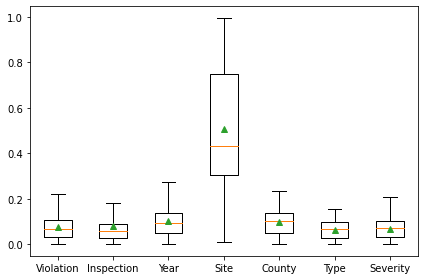

In [ ]:
#绘制attention 箱型图
import matplotlib.pyplot as plt

data=np.concatenate((code_weights,ins_weights,year_weights,site_weights,county_weights,type_weights,sev_weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County','Type','Severity'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_model3_all.png',dpi=500)

plt.show()

In [ ]:
#保存整个模型 以便后续分析
model.save('/content/drive/My Drive/unconventional oil and gas/model_treatment.h5')

In [ ]:
#加载保存过的模型继续训练
new_model=tf.keras.models.load_model('/content/drive/My Drive/unconventional oil and gas/model_identification.h5')
#显示整个模型
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
new_model.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_identification')

In [ ]:
#在测试集上测试效果
new_model.evaluate(x=[year_test,ins_test,op_test,site_test,county_test],
               y=[label_test,b])

571/571 [==============================] - 19s 34ms/step - loss: 2.8996 - output_loss: 2.8996 - output_binary_accuracy: 0.7337 - output_auc: 0.5296 - output_precision: 0.6732 - output_recall: 0.3512


[2.8995521068573,
 2.8995521068573,
 0.7336691617965698,
 0.5295611619949341,
 0.6732321381568909,
 0.35118746757507324]

# 视觉展示不同结果的attention weights

In [ ]:
#没有发生违规事故的数据集 不要运行此段
# 创建treatment7个集合
#0
year_0=ma.array(year_np,mask=masks_0).compressed()
code_0=ma.array(code_np,mask=masks_0.repeat(128)).compressed()
code_0=np.reshape(code_0,(-1,128))
ins_0=ma.array(ins_np,mask=masks_0.repeat(128)).compressed()
ins_0=np.reshape(ins_0,(-1,128))
county_0=ma.array(county_np,mask=masks_0).compressed()
siteid_0=ma.array(siteid_np,mask=masks_0).compressed()
operator_0=ma.array(operator_np,mask=masks_0).compressed()
type_0=ma.array(type_np,mask=masks_0).compressed()
sev_0=ma.array(sev_np,mask=masks_0).compressed()

#1
year_1=ma.array(year_np,mask=masks_1).compressed()
code_1=ma.array(code_np,mask=masks_1.repeat(128)).compressed()
code_1=np.reshape(code_1,(-1,128))
ins_1=ma.array(ins_np,mask=masks_1.repeat(128)).compressed()
ins_1=np.reshape(ins_1,(-1,128))
county_1=ma.array(county_np,mask=masks_1).compressed()
siteid_1=ma.array(siteid_np,mask=masks_1).compressed()
operator_1=ma.array(operator_np,mask=masks_1).compressed()
type_1=ma.array(type_np,mask=masks_1).compressed()
sev_1=ma.array(sev_np,mask=masks_1).compressed()

#2
year_2=ma.array(year_np,mask=masks_2).compressed()
code_2=ma.array(code_np,mask=masks_2.repeat(128)).compressed()
code_2=np.reshape(code_2,(-1,128))
ins_2=ma.array(ins_np,mask=masks_2.repeat(128)).compressed()
ins_2=np.reshape(ins_2,(-1,128))
county_2=ma.array(county_np,mask=masks_2).compressed()
siteid_2=ma.array(siteid_np,mask=masks_2).compressed()
operator_2=ma.array(operator_np,mask=masks_2).compressed()
type_2=ma.array(type_np,mask=masks_2).compressed()
sev_2=ma.array(sev_np,mask=masks_2).compressed()

#3
year_3=ma.array(year_np,mask=masks_3).compressed()
code_3=ma.array(code_np,mask=masks_3.repeat(128)).compressed()
code_3=np.reshape(code_3,(-1,128))
ins_3=ma.array(ins_np,mask=masks_3.repeat(128)).compressed()
ins_3=np.reshape(ins_3,(-1,128))
county_3=ma.array(county_np,mask=masks_3).compressed()
siteid_3=ma.array(siteid_np,mask=masks_3).compressed()
operator_3=ma.array(operator_np,mask=masks_3).compressed()
type_3=ma.array(type_np,mask=masks_3).compressed()
sev_3=ma.array(sev_np,mask=masks_3).compressed()

#4
year_4=ma.array(year_np,mask=masks_4).compressed()
code_4=ma.array(code_np,mask=masks_4.repeat(128)).compressed()
code_4=np.reshape(code_4,(-1,128))
ins_4=ma.array(ins_np,mask=masks_4.repeat(128)).compressed()
ins_4=np.reshape(ins_4,(-1,128))
county_4=ma.array(county_np,mask=masks_4).compressed()
siteid_4=ma.array(siteid_np,mask=masks_4).compressed()
operator_4=ma.array(operator_np,mask=masks_4).compressed()
type_4=ma.array(type_np,mask=masks_4).compressed()
sev_4=ma.array(sev_np,mask=masks_4).compressed()

#5
year_5=ma.array(year_np,mask=masks_5).compressed()
code_5=ma.array(code_np,mask=masks_5.repeat(128)).compressed()
code_5=np.reshape(code_5,(-1,128))
ins_5=ma.array(ins_np,mask=masks_5.repeat(128)).compressed()
ins_5=np.reshape(ins_5,(-1,128))
county_5=ma.array(county_np,mask=masks_5).compressed()
siteid_5=ma.array(siteid_np,mask=masks_5).compressed()
operator_5=ma.array(operator_np,mask=masks_5).compressed()
type_5=ma.array(type_np,mask=masks_5).compressed()
sev_5=ma.array(sev_np,mask=masks_5).compressed()

#6
year_6=ma.array(year_np,mask=masks_6).compressed()
code_6=ma.array(code_np,mask=masks_6.repeat(128)).compressed()
code_6=np.reshape(code_6,(-1,128))
ins_6=ma.array(ins_np,mask=masks_6.repeat(128)).compressed()
ins_6=np.reshape(ins_6,(-1,128))
county_6=ma.array(county_np,mask=masks_6).compressed()
siteid_6=ma.array(siteid_np,mask=masks_6).compressed()
operator_6=ma.array(operator_np,mask=masks_6).compressed()
type_6=ma.array(type_np,mask=masks_6).compressed()
sev_6=ma.array(sev_np,mask=masks_6).compressed()

In [ ]:
# 模型拟合没有发生过违规事故的数据库
_,weight_0=model_bigru.predict([year_0,code_0,ins_0,operator_0,siteid_0,county_0,type_0,sev_0])

In [ ]:
weight_0.shape

(5001, 1, 7)

In [ ]:
#取 inspection, y s c 的 attention weights
code_0weights=weight_0[:,:,0] 
ins_0weights=weight_0[:,:,1] 
year_0weights=weight_0[:,:,2] 
site_0weights=weight_0[:,:,3]
county_0weights=weight_0[:,:,4]
type_0weights=weight_0[:,:,5]
sev_0weights=weight_0[:,:,6]

In [ ]:
#统计数值 4 个维度
#最大值
print('code max',np.amax(code_0weights))
print('ins max',np.amax(ins_0weights))
print('year max',np.amax(year_0weights))
print('site max',np.amax(site_0weights))
print('county max',np.amax(county_0weights))
print('type max',np.amax(type_0weights))
print('sev max',np.amax(sev_0weights))

#平均值
print('code mean',np.mean(code_0weights))
print('ins mean',np.mean(ins_0weights))
print('year mean',np.mean(year_0weights))
print('site mean',np.mean(site_0weights))
print('county mean',np.mean(county_0weights))
print('type mean',np.mean(type_0weights))
print('sev mean',np.mean(sev_0weights))

#中值
print('code median',np.median(code_0weights))
print('inspection median',np.median(ins_0weights))
print('year median',np.median(year_0weights))
print('site median',np.median(site_0weights))
print('county median',np.median(county_0weights))
print('type median',np.median(type_0weights))
print('sev median',np.median(sev_0weights))

#方差
print('code var',np.var(code_0weights))
print('ins var',np.var(ins_0weights))
print('year var',np.var(year_0weights))
print('site var',np.var(site_0weights))
print('county var',np.var(county_0weights))
print('type var',np.var(type_0weights))
print('sev var',np.var(sev_0weights))

code max 0.3113708
ins max 0.94818157
year max 0.48101753
site max 0.99649245
county max 0.6090929
type max 0.15469797
sev max 0.30084598
code mean 0.06428127
ins mean 0.056120947
year mean 0.09000076
site mean 0.58539766
county mean 0.087703414
type mean 0.056558724
sev mean 0.059937183
code median 0.052477956
inspection median 0.046116803
year median 0.07813105
site median 0.6276373
county median 0.08047341
type median 0.052014444
sev median 0.05459339
code var 0.0022514171
ins var 0.004076029
year var 0.0039278707
site var 0.062070165
county var 0.003519543
type var 0.0013403437
sev var 0.0015545696


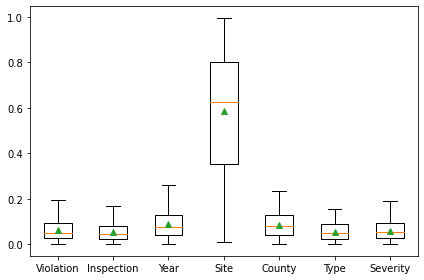

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_0weights,ins_0weights,year_0weights,site_0weights,county_0weights,type_0weights,sev_0weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County','Type','Severity'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_ef0_model3.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合 1
_,weight_1=model_bigru.predict([year_1,code_1,ins_1,operator_1,siteid_1,county_1,type_1,sev_1])

In [ ]:
weight_1.shape

(1280, 1, 7)

In [ ]:
#取 inspection, y s c 的 attention weights
code_1weights=weight_1[:,:,0] 
ins_1weights=weight_1[:,:,1] 
year_1weights=weight_1[:,:,2] 
site_1weights=weight_1[:,:,3]
county_1weights=weight_1[:,:,4]
type_1weights=weight_1[:,:,5]
sev_1weights=weight_1[:,:,6]

In [ ]:
#统计数值 4 个维度
#最大值
print('code max',np.amax(code_1weights))
print('ins max',np.amax(ins_1weights))
print('year max',np.amax(year_1weights))
print('site max',np.amax(site_1weights))
print('county max',np.amax(county_1weights))
print('type max',np.amax(type_1weights))
print('sev max',np.amax(sev_1weights))

#平均值
print('code mean',np.mean(code_1weights))
print('ins mean',np.mean(ins_1weights))
print('year mean',np.mean(year_1weights))
print('site mean',np.mean(site_1weights))
print('county mean',np.mean(county_1weights))
print('type mean',np.mean(type_1weights))
print('sev mean',np.mean(sev_1weights))

#中值
print('code median',np.median(code_1weights))
print('inspection median',np.median(ins_1weights))
print('year median',np.median(year_1weights))
print('site median',np.median(site_1weights))
print('county median',np.median(county_1weights))
print('type median',np.median(type_1weights))
print('sev median',np.median(sev_1weights))

#方差
print('code var',np.var(code_1weights))
print('ins var',np.var(ins_1weights))
print('year var',np.var(year_1weights))
print('site var',np.var(site_1weights))
print('county var',np.var(county_1weights))
print('type var',np.var(type_1weights))
print('sev var',np.var(sev_1weights))

code max 0.3180297
ins max 0.55124104
year max 0.42247552
site max 0.96469474
county max 0.23498735
type max 0.14219312
sev max 0.3202116
code mean 0.09969659
ins mean 0.085362494
year mean 0.13249512
site mean 0.37767425
county mean 0.124016285
type mean 0.08425452
sev mean 0.09650073
code median 0.09865447
inspection median 0.08700855
year median 0.12675522
site median 0.35644194
county median 0.12501357
type median 0.08932005
sev median 0.09669168
code var 0.002027357
ins var 0.001537069
year var 0.002665618
site var 0.0193773
county var 0.0013079277
type var 0.00063826115
sev var 0.0012711365


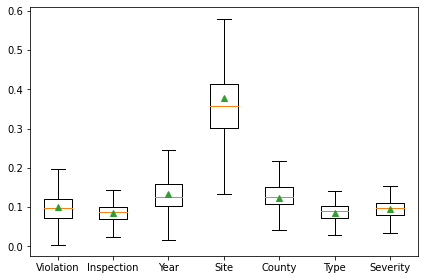

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_1weights,ins_1weights,year_1weights,site_1weights,county_1weights,type_1weights,sev_1weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County','Type','Severity'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_ef1_model3.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合 2
_,weight_2=model_bigru.predict([year_2,code_2,ins_2,operator_2,siteid_2,county_2,type_2,sev_2])

In [ ]:
weight_2.shape

(226, 1, 7)

In [ ]:
#取 inspection, y s c 的 attention weights
code_2weights=weight_2[:,:,0] 
ins_2weights=weight_2[:,:,1] 
year_2weights=weight_2[:,:,2] 
site_2weights=weight_2[:,:,3]
county_2weights=weight_2[:,:,4]
type_2weights=weight_2[:,:,5]
sev_2weights=weight_2[:,:,6]

In [ ]:
#统计数值 4 个维度
#最大值
print('code max',np.amax(code_2weights))
print('ins max',np.amax(ins_2weights))
print('year max',np.amax(year_2weights))
print('site max',np.amax(site_2weights))
print('county max',np.amax(county_2weights))
print('type max',np.amax(type_2weights))
print('sev max',np.amax(sev_2weights))

#平均值
print('code mean',np.mean(code_2weights))
print('ins mean',np.mean(ins_2weights))
print('year mean',np.mean(year_2weights))
print('site mean',np.mean(site_2weights))
print('county mean',np.mean(county_2weights))
print('type mean',np.mean(type_2weights))
print('sev mean',np.mean(sev_2weights))

#中值
print('code median',np.median(code_2weights))
print('inspection median',np.median(ins_2weights))
print('year median',np.median(year_2weights))
print('site median',np.median(site_2weights))
print('county median',np.median(county_2weights))
print('type median',np.median(type_2weights))
print('sev median',np.median(sev_2weights))

#方差
print('code var',np.var(code_2weights))
print('ins var',np.var(ins_2weights))
print('year var',np.var(year_2weights))
print('site var',np.var(site_2weights))
print('county var',np.var(county_2weights))
print('type var',np.var(type_2weights))
print('sev var',np.var(sev_2weights))

code max 0.22062433
ins max 0.2999782
year max 0.33430314
site max 0.70186144
county max 0.2202593
type max 0.14703642
sev max 0.18112287
code mean 0.13121638
ins mean 0.11090258
year mean 0.19293165
site mean 0.22436088
county mean 0.13538781
type mean 0.10030046
sev mean 0.10490024
code median 0.12768096
inspection median 0.09687918
year median 0.16947748
site median 0.18462765
county median 0.13236743
type median 0.101964146
sev median 0.106895365
code var 0.0021259624
ins var 0.0036796078
year var 0.004444
site var 0.014183475
county var 0.001513304
type var 0.00048039536
sev var 0.0005905892


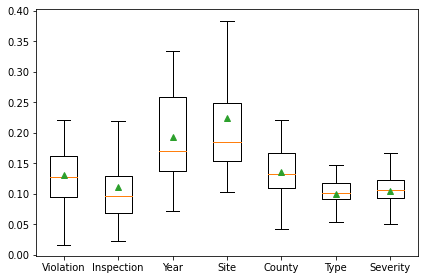

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_2weights,ins_2weights,year_2weights,site_2weights,county_2weights,type_2weights,sev_2weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County','Type','Severity'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_ef2_model3.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合 3
_,weight_3=model_bigru.predict([year_3,code_3,ins_3,operator_3,siteid_3,county_3,type_3,sev_3])

In [ ]:
weight_3.shape

(180, 1, 7)

In [ ]:
#取 inspection, y s c 的 attention weights
code_3weights=weight_3[:,:,0] 
ins_3weights=weight_3[:,:,1] 
year_3weights=weight_3[:,:,2] 
site_3weights=weight_3[:,:,3]
county_3weights=weight_3[:,:,4]
type_3weights=weight_3[:,:,5]
sev_3weights=weight_3[:,:,6]

In [ ]:
#统计数值 4 个维度
#最大值
print('code max',np.amax(code_3weights))
print('ins max',np.amax(ins_3weights))
print('year max',np.amax(year_3weights))
print('site max',np.amax(site_3weights))
print('county max',np.amax(county_3weights))
print('type max',np.amax(type_3weights))
print('sev max',np.amax(sev_3weights))

#平均值
print('code mean',np.mean(code_3weights))
print('ins mean',np.mean(ins_3weights))
print('year mean',np.mean(year_3weights))
print('site mean',np.mean(site_3weights))
print('county mean',np.mean(county_3weights))
print('type mean',np.mean(type_3weights))
print('sev mean',np.mean(sev_3weights))

#中值
print('code median',np.median(code_3weights))
print('inspection median',np.median(ins_3weights))
print('year median',np.median(year_3weights))
print('site median',np.median(site_3weights))
print('county median',np.median(county_3weights))
print('type median',np.median(type_3weights))
print('sev median',np.median(sev_3weights))

#方差
print('code var',np.var(code_3weights))
print('ins var',np.var(ins_3weights))
print('year var',np.var(year_3weights))
print('site var',np.var(site_3weights))
print('county var',np.var(county_3weights))
print('type var',np.var(type_3weights))
print('sev var',np.var(sev_3weights))

code max 0.3200867
ins max 0.5803058
year max 0.17339855
site max 0.1411733
county max 0.5055147
type max 0.11740625
sev max 0.25247756
code mean 0.14415158
ins mean 0.28815252
year mean 0.105546296
site mean 0.090261914
county mean 0.18139017
type mean 0.082402125
sev mean 0.108095445
code median 0.12132985
inspection median 0.2798171
year median 0.1000562
site median 0.09205101
county median 0.12247954
type median 0.084904365
sev median 0.10209682
code var 0.005736334
ins var 0.038429655
year var 0.0011556636
site var 0.0005947702
county var 0.017484337
type var 0.00041703184
sev var 0.0029923532


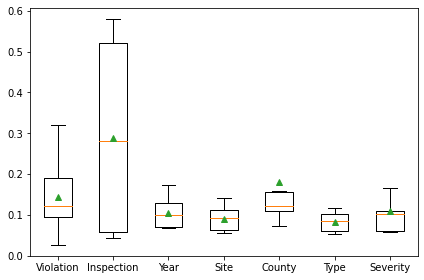

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_3weights,ins_3weights,year_3weights,site_3weights,county_3weights,type_3weights,sev_3weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County','Type','Severity'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_ef3_model3.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合 4
_,weight_4=model_bigru.predict([year_4,code_4,ins_4,operator_4,siteid_4,county_4,type_4,sev_4])

In [ ]:
weight_4.shape

(100, 1, 7)

In [ ]:
#取 inspection, y s c 的 attention weights
code_4weights=weight_4[:,:,0] 
ins_4weights=weight_4[:,:,1] 
year_4weights=weight_4[:,:,2] 
site_4weights=weight_4[:,:,3]
county_4weights=weight_4[:,:,4]
type_4weights=weight_4[:,:,5]
sev_4weights=weight_4[:,:,6]

In [ ]:
#统计数值 4 个维度
#最大值
print('code max',np.amax(code_4weights))
print('ins max',np.amax(ins_4weights))
print('year max',np.amax(year_4weights))
print('site max',np.amax(site_4weights))
print('county max',np.amax(county_4weights))
print('type max',np.amax(type_4weights))
print('sev max',np.amax(sev_4weights))

#平均值
print('code mean',np.mean(code_4weights))
print('ins mean',np.mean(ins_4weights))
print('year mean',np.mean(year_4weights))
print('site mean',np.mean(site_4weights))
print('county mean',np.mean(county_4weights))
print('type mean',np.mean(type_4weights))
print('sev mean',np.mean(sev_4weights))

#中值
print('code median',np.median(code_4weights))
print('inspection median',np.median(ins_4weights))
print('year median',np.median(year_4weights))
print('site median',np.median(site_4weights))
print('county median',np.median(county_4weights))
print('type median',np.median(type_4weights))
print('sev median',np.median(sev_4weights))

#方差
print('code var',np.var(code_4weights))
print('ins var',np.var(ins_4weights))
print('year var',np.var(year_4weights))
print('site var',np.var(site_4weights))
print('county var',np.var(county_4weights))
print('type var',np.var(type_4weights))
print('sev var',np.var(sev_4weights))

code max 0.055020425
ins max 0.94818157
year max 0.14834946
site max 0.06828983
county max 0.074364334
type max 0.063585274
sev max 0.06410496
code mean 0.013395436
ins mean 0.86243826
year mean 0.03937995
site mean 0.021609647
county mean 0.023352796
type mean 0.01986502
sev mean 0.019958964
code median 0.006356205
inspection median 0.94257516
year median 0.012344327
site median 0.010039188
county median 0.01070813
type median 0.00905307
sev median 0.009015533
code var 0.00026113627
ins var 0.026201425
year var 0.002926565
site var 0.00053647795
county var 0.0006406887
type var 0.00046890814
sev var 0.00047986448


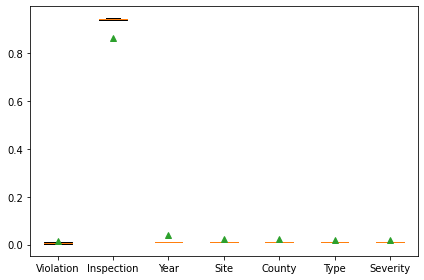

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_4weights,ins_4weights,year_4weights,site_4weights,county_4weights,type_4weights,sev_4weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County','Type','Severity'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_ef4_model3.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合 5
_,weight_5=model_bigru.predict([year_5,code_5,ins_5,operator_5,siteid_5,county_5,type_5,sev_5])

In [ ]:
#取 inspection, y s c 的 attention weights
code_5weights=weight_5[:,:,0] 
ins_5weights=weight_5[:,:,1] 
year_5weights=weight_5[:,:,2] 
site_5weights=weight_5[:,:,3]
county_5weights=weight_5[:,:,4]
type_5weights=weight_5[:,:,5]
sev_5weights=weight_5[:,:,6]

In [ ]:
#统计数值 4 个维度
#最大值
print('code max',np.amax(code_5weights))
print('ins max',np.amax(ins_5weights))
print('year max',np.amax(year_5weights))
print('site max',np.amax(site_5weights))
print('county max',np.amax(county_5weights))
print('type max',np.amax(type_5weights))
print('sev max',np.amax(sev_5weights))

#平均值
print('code mean',np.mean(code_5weights))
print('ins mean',np.mean(ins_5weights))
print('year mean',np.mean(year_5weights))
print('site mean',np.mean(site_5weights))
print('county mean',np.mean(county_5weights))
print('type mean',np.mean(type_5weights))
print('sev mean',np.mean(sev_5weights))

#中值
print('code median',np.median(code_5weights))
print('inspection median',np.median(ins_5weights))
print('year median',np.median(year_5weights))
print('site median',np.median(site_5weights))
print('county median',np.median(county_5weights))
print('type median',np.median(type_5weights))
print('sev median',np.median(sev_5weights))

#方差
print('code var',np.var(code_5weights))
print('ins var',np.var(ins_5weights))
print('year var',np.var(year_5weights))
print('site var',np.var(site_5weights))
print('county var',np.var(county_5weights))
print('type var',np.var(type_5weights))
print('sev var',np.var(sev_5weights))

code max 0.15974444
ins max 0.22624083
year max 0.33430314
site max 0.43816626
county max 0.20029563
type max 0.14703642
sev max 0.18112287
code mean 0.12749544
ins mean 0.119890906
year mean 0.14775072
site mean 0.17600447
county mean 0.17816673
type mean 0.122580506
sev mean 0.12811127
code median 0.13971825
inspection median 0.09620136
year median 0.13531649
site median 0.16378409
county median 0.18646154
type median 0.12479547
sev median 0.12855986
code var 0.00088005373
ins var 0.0020469504
year var 0.00126937
site var 0.002667126
county var 0.00050111115
type var 0.00010251441
sev var 0.00018749753


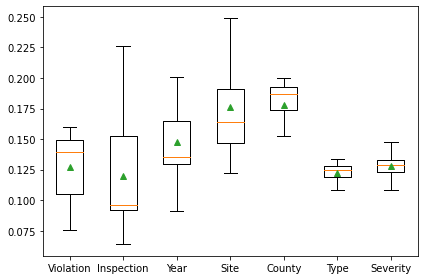

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_5weights,ins_5weights,year_5weights,site_5weights,county_5weights,type_5weights,sev_5weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County','Type','Severity'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_ef5_model3.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合 6
_,weight_6=model_bigru.predict([year_6,code_6,ins_6,operator_6,siteid_6,county_6,type_6,sev_6])

In [ ]:
#取 inspection, y s c 的 attention weights
code_6weights=weight_6[:,:,0] 
ins_6weights=weight_6[:,:,1] 
year_6weights=weight_6[:,:,2] 
site_6weights=weight_6[:,:,3]
county_6weights=weight_6[:,:,4]
type_6weights=weight_6[:,:,5]
sev_6weights=weight_6[:,:,6]

In [ ]:
#统计数值 4 个维度
#最大值
print('code max',np.amax(code_6weights))
print('ins max',np.amax(ins_6weights))
print('year max',np.amax(year_6weights))
print('site max',np.amax(site_6weights))
print('county max',np.amax(county_6weights))
print('type max',np.amax(type_6weights))
print('sev max',np.amax(sev_6weights))

#平均值
print('code mean',np.mean(code_6weights))
print('ins mean',np.mean(ins_6weights))
print('year mean',np.mean(year_6weights))
print('site mean',np.mean(site_6weights))
print('county mean',np.mean(county_6weights))
print('type mean',np.mean(type_6weights))
print('sev mean',np.mean(sev_6weights))

#中值
print('code median',np.median(code_6weights))
print('inspection median',np.median(ins_6weights))
print('year median',np.median(year_6weights))
print('site median',np.median(site_6weights))
print('county median',np.median(county_6weights))
print('type median',np.median(type_6weights))
print('sev median',np.median(sev_6weights))

#方差
print('code var',np.var(code_6weights))
print('ins var',np.var(ins_6weights))
print('year var',np.var(year_6weights))
print('site var',np.var(site_6weights))
print('county var',np.var(county_6weights))
print('type var',np.var(type_6weights))
print('sev var',np.var(sev_6weights))

code max 0.121830866
ins max 0.15574914
year max 0.13249892
site max 0.13378611
county max 0.20916061
type max 0.12537949
sev max 0.13913171
code mean 0.11858292
ins mean 0.1518796
year mean 0.13159403
site mean 0.13287242
county mean 0.20773217
type mean 0.12452324
sev mean 0.13281561
code median 0.118913114
inspection median 0.15462458
year median 0.13150808
site median 0.13278565
county median 0.20759648
type median 0.12444189
sev median 0.130925
code var 7.4767477e-06
ins var 2.9419656e-05
year var 4.306542e-07
site var 4.3905393e-07
county var 1.073148e-06
type var 3.8561012e-07
sev var 1.3453893e-05


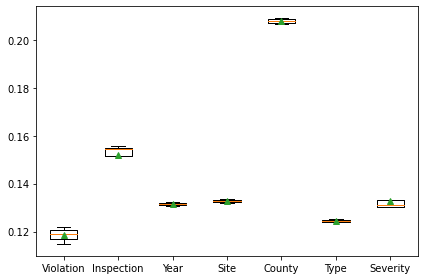

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_6weights,ins_6weights,year_6weights,site_6weights,county_6weights,type_6weights,sev_6weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County','Type','Severity'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_ef6_model3.png',dpi=500)

plt.show()

# LSTM

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))
input_t=Input(shape=(1,))
input_sev=Input(shape=(1,))

e_code=Embedding(1242,128,name='violation_code')(input_code) #(batch,128,128)
e_ins=Embedding(7437,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(19,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(107,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1301,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(38,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_t=Embedding(4,128,name='type')(input_t)
e_t=Dense(128,activation='relu')(e_t)
e_t=Dense(128,activation='relu')(e_t)

e_sev=Embedding(8,128,name='severity')(input_sev)
e_sev=Dense(128,activation='relu')(e_sev)
e_sev=Dense(128,activation='relu')(e_sev)


e_code=LSTM(128,activation='tanh')(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,1,128)

e_ins=LSTM(128,activation='tanh')(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_t,e_sev]) #(batch,7,128)
contextv,attention_score=Attention()([e_o,concate],return_attention_scores=True)

output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(7,activation='softmax',name='output_treatment')(output1) #(batch,1,7)
output1=tf.reshape(output1,(-1,7)) #(batch,7)


model_LSTM=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c,input_t,input_sev],
            outputs=[output1,attention_score])

In [ ]:
model_LSTM.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_lstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_LSTM.compile(optimizer='adam',loss=['categorical_crossentropy','binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[[m1,m2,m3,m4],[]]) #2个输出

In [ ]:
history=model_LSTM.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train,type_train,sev_train],y=[label_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.3780 - tf.reshape_1_loss: 1.3780 - attention_1_loss: 1.0606 - tf.reshape_1_tf.reshape_accuracy: 0.0000e+00 - tf.reshape_1_tf.reshape_categorical_accuracy: 0.6904 - tf.reshape_1_tf.reshape_precision: 0.7302 - tf.reshape_1_tf.reshape_recall: 0.3424
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_lstm/cp-01.ckpt
17/17 [==============================] - 35s 2s/step - loss: 1.3780 - tf.reshape_1_loss: 1.3780 - attention_1_loss: 1.0606 - tf.reshape_1_tf.reshape_accuracy: 0.0000e+00 - tf.reshape_1_tf.reshape_categorical_accuracy: 0.6904 - tf.reshape_1_tf.reshape_precision: 0.7302 - tf.reshape_1_tf.reshape_recall: 0.3424 - val_loss: 0.9099 - val_tf.reshape_1_loss: 0.9099 - val_attention_1_loss: 1.0587 - val_tf.reshape_1_tf.reshape_accuracy: 0.0000e+00 - val_tf.reshape_1_tf.reshape_categorical_accuracy: 0.7146 - val_tf.reshape_1_tf.reshape_precision: 0.7146 - val_tf.reshape

In [ ]:
model_LSTM.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_lstm/cp-09.ckpt')

In [ ]:
#在测试集上测试效果
model_LSTM.evaluate(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test],
               y=[label_test,b])

62/62 [==============================] - 5s 73ms/step - loss: 0.6555 - tf.reshape_loss: 0.6555 - attention_loss: 1.1283 - tf.reshape_accuracy: 0.0000e+00 - tf.reshape_categorical_accuracy: 0.7546 - tf.reshape_precision: 0.7546 - tf.reshape_recall: 0.7546


[0.6554775834083557,
 0.6554775834083557,
 1.1282857656478882,
 0.0,
 0.7545546293258667,
 0.7545546293258667,
 0.7545546293258667]

In [ ]:
prediction_lstm,_=model_LSTM.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test])
prediction_lstm=np.argmax(prediction_lstm,axis=1)
print('precision',precision_score(labelm_test,prediction_lstm,average='weighted'))
print('********************')
print('recall',recall_score(labelm_test,prediction_lstm,average='weighted'))
print('********************')
print('f1score',f1_score(labelm_test,prediction_lstm,average='weighted'))
print('********************')
print('accuracy',accuracy_score(labelm_test,prediction_lstm))

precision 0.7052968345932733
********************
recall 0.6948493683187561
********************
f1score 0.6971434574462512
********************
accuracy 0.6948493683187561


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BI-GRU

In [86]:
from tensorflow.keras.layers import Bidirectional

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))
input_t=Input(shape=(1,))
input_sev=Input(shape=(1,))

e_code=Embedding(1242,128,name='violation_code')(input_code) #(batch,128,128)
e_ins=Embedding(7437,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(19,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(107,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1301,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(38,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_t=Embedding(4,128,name='type')(input_t)
e_t=Dense(128,activation='relu')(e_t)
e_t=Dense(256,activation='relu')(e_t)

e_sev=Embedding(8,128,name='severity')(input_sev)
e_sev=Dense(128,activation='relu')(e_sev)
e_sev=Dense(256,activation='relu')(e_sev)


e_code=Bidirectional(GRU(128,activation='tanh'))(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,1,256)

e_ins=Bidirectional(GRU(128,activation='tanh'))(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_t,e_sev]) #(batch,7,256)
contextv,attention_score=Attention()([e_o,concate],return_attention_scores=True)

output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(7,activation='softmax',name='output_treatment')(output1) #(batch,1,7)
output1=tf.reshape(output1,(-1,7)) #(batch,7)


model_bigru=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c,input_t,input_sev],
            outputs=[output1,attention_score])

In [ ]:
model_bigru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_bigru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_bigru.compile(optimizer='adam',loss=['categorical_crossentropy','binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[[m1,m2,m3,m4],[]]) #2个输出

In [ ]:
history=model_bigru.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train,type_train,sev_train],y=[label_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.5386 - tf.reshape_2_loss: 1.5386 - attention_2_loss: 1.0569 - tf.reshape_2_tf.reshape_1_tf.reshape_accuracy: 0.0000e+00 - tf.reshape_2_tf.reshape_1_tf.reshape_categorical_accuracy: 0.6916 - tf.reshape_2_tf.reshape_1_tf.reshape_precision: 0.7172 - tf.reshape_2_tf.reshape_1_tf.reshape_recall: 0.2109
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_bigru/cp-01.ckpt
17/17 [==============================] - 58s 3s/step - loss: 1.5386 - tf.reshape_2_loss: 1.5386 - attention_2_loss: 1.0569 - tf.reshape_2_tf.reshape_1_tf.reshape_accuracy: 0.0000e+00 - tf.reshape_2_tf.reshape_1_tf.reshape_categorical_accuracy: 0.6916 - tf.reshape_2_tf.reshape_1_tf.reshape_precision: 0.7172 - tf.reshape_2_tf.reshape_1_tf.reshape_recall: 0.2109 - val_loss: 1.0709 - val_tf.reshape_2_loss: 1.0709 - val_attention_2_loss: 1.0568 - val_tf.reshape_2_tf.reshape_1_tf.reshape_accuracy: 0.0000e+00 - val

In [ ]:
model_bigru.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_bigru/cp-09.ckpt')

In [ ]:
#在测试集上测试效果
model_bigru.evaluate(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test],
               y=[label_test,b])

62/62 [==============================] - 7s 112ms/step - loss: 0.6681 - tf.reshape_1_loss: 0.6681 - attention_1_loss: 1.0472 - tf.reshape_1_tf.reshape_accuracy: 0.0000e+00 - tf.reshape_1_tf.reshape_categorical_accuracy: 0.7546 - tf.reshape_1_tf.reshape_precision: 0.7546 - tf.reshape_1_tf.reshape_recall: 0.7546


[0.6681403517723083,
 0.6681403517723083,
 1.0471889972686768,
 0.0,
 0.7545546293258667,
 0.7545546293258667,
 0.7545546293258667]

In [ ]:
prediction_bigru,_=model_bigru.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test])
prediction_bigru=np.argmax(prediction_bigru,axis=1)
print('precision',precision_score(labelm_test,prediction_bigru,average='weighted'))
print('********************')
print('recall',recall_score(labelm_test,prediction_bigru,average='weighted'))
print('********************')
print('f1score',f1_score(labelm_test,prediction_bigru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(labelm_test,prediction_bigru))

precision 0.7019096214027396
********************
recall 0.7011661807580175
********************
f1score 0.7007283310364367
********************
accuracy 0.7011661807580175


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BI-LSTM

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))
input_t=Input(shape=(1,))
input_sev=Input(shape=(1,))

e_code=Embedding(1242,128,name='violation_code')(input_code) #(batch,128,128)
e_ins=Embedding(7437,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(19,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(107,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1301,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(38,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_t=Embedding(4,128,name='type')(input_t)
e_t=Dense(128,activation='relu')(e_t)
e_t=Dense(256,activation='relu')(e_t)

e_sev=Embedding(8,128,name='severity')(input_sev)
e_sev=Dense(128,activation='relu')(e_sev)
e_sev=Dense(256,activation='relu')(e_sev)


e_code=Bidirectional(LSTM(128,activation='tanh'))(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,1,256)

e_ins=Bidirectional(LSTM(128,activation='tanh'))(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_t,e_sev]) #(batch,7,256)
contextv,attention_score=Attention()([e_o,concate],return_attention_scores=True)

output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(7,activation='softmax',name='output_treatment')(output1) #(batch,1,7)
output1=tf.reshape(output1,(-1,7)) #(batch,7)


model_bilstm=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c,input_t,input_sev],
            outputs=[output1,attention_score])

In [ ]:
model_bilstm.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_bilstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_bilstm.compile(optimizer='adam',loss=['categorical_crossentropy','binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[[m1,m2,m3,m4],[]]) #2个输出

In [ ]:
history=model_bilstm.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train,type_train,sev_train],y=[label_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.3409 - tf.reshape_3_loss: 1.3409 - attention_3_loss: 1.0587 - tf.reshape_3_tf.reshape_2_tf.reshape_1_tf.reshape_accuracy: 0.0000e+00 - tf.reshape_3_tf.reshape_2_tf.reshape_1_tf.reshape_categorical_accuracy: 0.7212 - tf.reshape_3_tf.reshape_2_tf.reshape_1_tf.reshape_precision: 0.7159 - tf.reshape_3_tf.reshape_2_tf.reshape_1_tf.reshape_recall: 0.3734
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_bilstm/cp-01.ckpt
17/17 [==============================] - 63s 3s/step - loss: 1.3409 - tf.reshape_3_loss: 1.3409 - attention_3_loss: 1.0587 - tf.reshape_3_tf.reshape_2_tf.reshape_1_tf.reshape_accuracy: 0.0000e+00 - tf.reshape_3_tf.reshape_2_tf.reshape_1_tf.reshape_categorical_accuracy: 0.7212 - tf.reshape_3_tf.reshape_2_tf.reshape_1_tf.reshape_precision: 0.7159 - tf.reshape_3_tf.reshape_2_tf.reshape_1_tf.reshape_recall: 0.3734 - val_loss: 0.9055 - val_tf.reshape_3_loss: 0.

In [ ]:
model_bilstm.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_bilstm/cp-07.ckpt')

In [ ]:
#在测试集上测试效果
model_bilstm.evaluate(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test],
               y=[label_test,b])

62/62 [==============================] - 9s 140ms/step - loss: 0.6866 - tf.reshape_2_loss: 0.6866 - attention_2_loss: 1.2099 - tf.reshape_2_tf.reshape_1_tf.reshape_accuracy: 9.3985e-04 - tf.reshape_2_tf.reshape_1_tf.reshape_categorical_accuracy: 0.7586 - tf.reshape_2_tf.reshape_1_tf.reshape_precision: 0.7701 - tf.reshape_2_tf.reshape_1_tf.reshape_recall: 0.7257


[0.686615526676178,
 0.686615526676178,
 1.209929347038269,
 0.000939849647693336,
 0.7586032152175903,
 0.7701396346092224,
 0.7257084846496582]

In [ ]:
prediction_bilstm,_=model_bilstm.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test])
prediction_bilstm=np.argmax(prediction_bilstm,axis=1)
print('precision',precision_score(labelm_test,prediction_bilstm,average='weighted'))
print('********************')
print('recall',recall_score(labelm_test,prediction_bilstm,average='weighted'))
print('********************')
print('f1score',f1_score(labelm_test,prediction_bilstm,average='weighted'))
print('********************')
print('accuracy',accuracy_score(labelm_test,prediction_bilstm))

precision 0.7172630109485836
********************
recall 0.6827016520894071
********************
f1score 0.692407420331624
********************
accuracy 0.6827016520894071


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM


In [ ]:
year_train.shape

(4799,)

In [ ]:
from sklearn import svm,metrics
x=np.concatenate((np.expand_dims(year_train,axis=1),code_train,ins_train,np.expand_dims(operator_train,axis=1),np.expand_dims(siteid_train,axis=1),np.expand_dims(county_train,axis=1),np.expand_dims(type_train,axis=1),np.expand_dims(sev_train,axis=1)),axis=1)
x.shape

(4799, 262)

In [ ]:
# 准备数据
x=np.concatenate((np.expand_dims(year_train,axis=1),code_train,ins_train,np.expand_dims(operator_train,axis=1),np.expand_dims(siteid_train,axis=1),np.expand_dims(county_train,axis=1),np.expand_dims(type_train,axis=1),np.expand_dims(sev_train,axis=1)),axis=1)
x_test=np.concatenate((np.expand_dims(year_test,axis=1),code_test,ins_test,np.expand_dims(operator_test,axis=1),np.expand_dims(siteid_test,axis=1),np.expand_dims(county_test,axis=1),np.expand_dims(type_test,axis=1),np.expand_dims(sev_test,axis=1)),axis=1)

In [ ]:
labelm_train.shape

(4799,)

In [ ]:
clf=svm.SVC()
clf.fit(x,labelm_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# SVM 
clf=svm.SVC()
clf.fit(x,labelm_train)
predicted_svm=clf.predict(x_test)

In [ ]:
# 指标
print('accuracy',accuracy_score(labelm_test,predicted_svm))
print('*********************************')
print('precision',precision_score(labelm_test,predicted_svm,average='weighted'))
print('*********************************')
print('recall',recall_score(labelm_test,predicted_svm,average='weighted'))
print('*********************************')
print('f1',f1_score(labelm_test,predicted_svm,average='weighted'))

accuracy 0.7555879494655005
*********************************
precision 0.6705358153688364
*********************************
recall 0.7555879494655005
*********************************
f1 0.6723967839398172


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#acuracy
from sklearn.metrics import accuracy_score
accuracy_score(labelm_test,predicted_svm)

0.7444331983805668

In [ ]:
#precision
from sklearn.metrics import precision_score
precision_score(labelm_test,predicted_svm,average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.22478724197034056

In [ ]:
#recall
from sklearn.metrics import recall_score
recall_score(labelm_test,predicted_svm,average='macro')

0.15478848668009207

# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rf=RandomForestClassifier(max_depth=2,random_state=0)
clf_rf.fit(x,label_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
predicted_rf=clf_rf.predict(x_test)

In [ ]:
predicted_rf=np.argmax(predicted_rf,axis=1)

In [ ]:
# 指标
print('accuracy',accuracy_score(labelm_test,predicted_rf))
print('*********************************')
print('precision',precision_score(labelm_test,predicted_rf,average='weighted'))
print('*********************************')
print('recall',recall_score(labelm_test,predicted_rf,average='weighted'))
print('*********************************')
print('f1',f1_score(labelm_test,predicted_rf,average='weighted'))

accuracy 0.7303206997084548
*********************************
precision 0.533368324422647
*********************************
recall 0.7303206997084548
*********************************
f1 0.6164964962998076


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr=LogisticRegression(C=1e5).fit(x,labelm_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
predicted_lr=clf_lr.predict(x_test)

In [ ]:
# 指标
print('accuracy',accuracy_score(labelm_test,predicted_lr))
print('*********************************')
print('precision',precision_score(labelm_test,predicted_lr,average='weighted'))
print('*********************************')
print('recall',recall_score(labelm_test,predicted_lr,average='weighted'))
print('*********************************')
print('f1',f1_score(labelm_test,predicted_lr,average='weighted'))

accuracy 0.7351797862001944
*********************************
precision 0.6491800637961095
*********************************
recall 0.7351797862001944
*********************************
f1 0.6744172632327287


# Without attention-GRU

In [88]:
from tensorflow.keras.layers import Flatten

In [ ]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))
input_t=Input(shape=(1,))
input_sev=Input(shape=(1,))

e_code=Embedding(1242,128,name='violation_code')(input_code) #(batch,128,128)
e_ins=Embedding(7437,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(19,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(107,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1301,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(38,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_t=Embedding(4,128,name='type')(input_t)
e_t=Dense(128,activation='relu')(e_t)
e_t=Dense(128,activation='relu')(e_t)

e_sev=Embedding(8,128,name='severity')(input_sev)
e_sev=Dense(128,activation='relu')(e_sev)
e_sev=Dense(128,activation='relu')(e_sev)


e_code=GRU(128,activation='tanh')(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,1,128)

e_ins=GRU(128,activation='tanh')(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_t,e_sev,e_o]) #(batch,8,128)
concate=Flatten()(concate) # (batch,1024)
output=Dense(128,activation='relu')(concate) #(batch,128)
output=Dense(7,activation='softmax',name='output_treatment')(output) #(batch,7)


model_wg=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c,input_t,input_sev],
            outputs=[output])

In [ ]:
model_wg.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [ ]:
#使用earlystopping 
early_stopping=tf.keras.callbacks.EarlyStopping(patience=10)

In [ ]:
m2=tf.keras.metrics.CategoricalAccuracy()

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutgru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#确定优化器、损失函数、准则
model_wg.compile(optimizer='adam',loss=['categorical_crossentropy'],
              metrics=[m2]) 

In [ ]:
model_wg.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train,type_train,sev_train],y=[label_train],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.2090 - categorical_accuracy: 0.7115
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutgru/cp-01.ckpt
17/17 [==============================] - 29s 1s/step - loss: 1.2090 - categorical_accuracy: 0.7115 - val_loss: 0.8772 - val_categorical_accuracy: 0.7146
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.8058 - categorical_accuracy: 0.7305
Epoch 00002: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutgru/cp-02.ckpt
17/17 [==============================] - 23s 1s/step - loss: 0.8058 - categorical_accuracy: 0.7305 - val_loss: 0.8048 - val_categorical_accuracy: 0.7146
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.6749 - categorical_accuracy: 0.7356
Epoch 00003: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutgru/cp-03.ckpt
17/17 [

In [ ]:
model_wg.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutgru/cp-05.ckpt')

In [ ]:
model_wg.evaluate(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test],
               y=[label_test])

62/62 [==============================] - 3s 48ms/step - loss: 0.6335 - categorical_accuracy: 0.7449


[0.6334936618804932, 0.7449392676353455]

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru=model_wg.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test])
prediction_gru=np.argmax(prediction_gru,axis=1)
print('precision',precision_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(labelm_test,prediction_gru))

precision 0.7017335351505323
********************
recall 0.7074829931972789
********************
f1score 0.7026962127754391
********************
accuracy 0.7074829931972789


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Without attention-BiGru

In [89]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))
input_t=Input(shape=(1,))
input_sev=Input(shape=(1,))

e_code=Embedding(1242,128,name='violation_code')(input_code) #(batch,128,128)
e_ins=Embedding(7437,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(19,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(107,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1301,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(38,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_t=Embedding(4,128,name='type')(input_t)
e_t=Dense(128,activation='relu')(e_t)
e_t=Dense(256,activation='relu')(e_t)

e_sev=Embedding(8,128,name='severity')(input_sev)
e_sev=Dense(128,activation='relu')(e_sev)
e_sev=Dense(256,activation='relu')(e_sev)


e_code=Bidirectional(GRU(128,activation='tanh'))(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,1,256)

e_ins=Bidirectional(GRU(128,activation='tanh'))(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_t,e_sev,e_o]) #(batch,8,256)
concate=Flatten()(concate) # (batch,2048)
output=Dense(128,activation='relu')(concate) #(batch,128)
output=Dense(7,activation='softmax',name='output_treatment')(output) #(batch,7)


model_wbg=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c,input_t,input_sev],
            outputs=[output])

In [90]:
model_wbg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutbigru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [91]:
#确定优化器、损失函数、准则
model_wbg.compile(optimizer='adam',loss=['categorical_crossentropy'],
              metrics=[m2]) 

In [ ]:
model_wbg.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train,type_train,sev_train],y=[label_train],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.2143 - categorical_accuracy: 0.6891
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutbigru/cp-01.ckpt
17/17 [==============================] - 55s 3s/step - loss: 1.2143 - categorical_accuracy: 0.6891 - val_loss: 0.8822 - val_categorical_accuracy: 0.7146
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.7932 - categorical_accuracy: 0.7305
Epoch 00002: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutbigru/cp-02.ckpt
17/17 [==============================] - 45s 3s/step - loss: 0.7932 - categorical_accuracy: 0.7305 - val_loss: 0.7724 - val_categorical_accuracy: 0.7146
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.6281 - categorical_accuracy: 0.7395
Epoch 00003: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutbigru/cp-03.ckpt
1

In [92]:
model_wbg.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutbigru/cp-04.ckpt')

In [93]:
model_wbg.evaluate(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test],
               y=[label_test])

65/65 [==============================] - 8s 94ms/step - loss: 0.5987 - categorical_accuracy: 0.7303


[0.5986576080322266, 0.7303206920623779]

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru=model_wbg.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test])
prediction_gru=np.argmax(prediction_gru,axis=1)
print('precision',precision_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(labelm_test,prediction_gru))

precision 0.6786106346412235
********************
recall 0.7293488824101069
********************
f1score 0.698264080396523
********************
accuracy 0.7293488824101069


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Without attention LSTM

In [94]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten

In [95]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))
input_t=Input(shape=(1,))
input_sev=Input(shape=(1,))

e_code=Embedding(1242,128,name='violation_code')(input_code) #(batch,128,128)
e_ins=Embedding(7437,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(19,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(107,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1301,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(38,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_t=Embedding(4,128,name='type')(input_t)
e_t=Dense(128,activation='relu')(e_t)
e_t=Dense(128,activation='relu')(e_t)

e_sev=Embedding(8,128,name='severity')(input_sev)
e_sev=Dense(128,activation='relu')(e_sev)
e_sev=Dense(128,activation='relu')(e_sev)


e_code=LSTM(128,activation='tanh')(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,1,128)

e_ins=LSTM(128,activation='tanh')(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_t,e_sev,e_o]) #(batch,8,128)
concate=Flatten()(concate) # (batch,1024)
output=Dense(128,activation='relu')(concate) #(batch,128)
output=Dense(7,activation='softmax',name='output_treatment')(output) #(batch,7)


model_wl=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c,input_t,input_sev],
            outputs=[output])

In [96]:
model_wl.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutlstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [ ]:
#使用earlystopping 
early_stopping=tf.keras.callbacks.EarlyStopping(patience=10)

In [97]:
#确定优化器、损失函数、准则
model_wl.compile(optimizer='adam',loss=['categorical_crossentropy'],
              metrics=[m2]) 

In [ ]:
model_wl.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train,type_train,sev_train],y=[label_train],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.2464 - categorical_accuracy: 0.6897
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutlstm/cp-01.ckpt
17/17 [==============================] - 32s 2s/step - loss: 1.2464 - categorical_accuracy: 0.6897 - val_loss: 0.8917 - val_categorical_accuracy: 0.7146
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.8159 - categorical_accuracy: 0.7305
Epoch 00002: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutlstm/cp-02.ckpt
17/17 [==============================] - 26s 2s/step - loss: 0.8159 - categorical_accuracy: 0.7305 - val_loss: 0.7991 - val_categorical_accuracy: 0.7146
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.6837 - categorical_accuracy: 0.7393
Epoch 00003: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutlstm/cp-03.ckpt
17/1

In [98]:
model_wl.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutlstm/cp-06.ckpt')

In [99]:
model_wl.evaluate(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test],
               y=[label_test])

65/65 [==============================] - 6s 64ms/step - loss: 0.6210 - categorical_accuracy: 0.7228


[0.6210119724273682, 0.7227891087532043]

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru=model_wl.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test])
prediction_gru=np.argmax(prediction_gru,axis=1)
print('precision',precision_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(labelm_test,prediction_gru))

precision 0.6833521971205258
********************
recall 0.717201166180758
********************
f1score 0.6980598635686904
********************
accuracy 0.717201166180758


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Without attention BILSTM

In [100]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))
input_t=Input(shape=(1,))
input_sev=Input(shape=(1,))

e_code=Embedding(1242,128,name='violation_code')(input_code) #(batch,128,128)
e_ins=Embedding(7437,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(19,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(107,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1301,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(38,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_t=Embedding(4,128,name='type')(input_t)
e_t=Dense(128,activation='relu')(e_t)
e_t=Dense(256,activation='relu')(e_t)

e_sev=Embedding(8,128,name='severity')(input_sev)
e_sev=Dense(128,activation='relu')(e_sev)
e_sev=Dense(256,activation='relu')(e_sev)


e_code=Bidirectional(LSTM(128,activation='tanh'))(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,1,256)

e_ins=Bidirectional(LSTM(128,activation='tanh'))(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_t,e_sev,e_o]) #(batch,8,256)
concate=Flatten()(concate) # (batch,2048)
output=Dense(128,activation='relu')(concate) #(batch,128)
output=Dense(7,activation='softmax',name='output_treatment')(output) #(batch,7)


model_wbl=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c,input_t,input_sev],
            outputs=[output])

In [101]:
model_wbl.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_41 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutbilstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [102]:
#确定优化器、损失函数、准则
model_wbl.compile(optimizer='adam',loss=['categorical_crossentropy'],
              metrics=[m2]) 

In [ ]:
model_wbl.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train,type_train,sev_train],y=[label_train],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.1553 - categorical_accuracy: 0.7041
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutbilstm/cp-01.ckpt
17/17 [==============================] - 65s 3s/step - loss: 1.1553 - categorical_accuracy: 0.7041 - val_loss: 0.8650 - val_categorical_accuracy: 0.7146
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.7721 - categorical_accuracy: 0.7312
Epoch 00002: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutbilstm/cp-02.ckpt
17/17 [==============================] - 52s 3s/step - loss: 0.7721 - categorical_accuracy: 0.7312 - val_loss: 0.7524 - val_categorical_accuracy: 0.7188
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.6108 - categorical_accuracy: 0.7411
Epoch 00003: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutbilstm/cp-03.ckp

In [103]:
model_wbl.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_treatment_withoutbilstm/cp-05.ckpt')

In [104]:
model_wbl.evaluate(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test],
               y=[label_test])

65/65 [==============================] - 10s 119ms/step - loss: 0.5950 - categorical_accuracy: 0.7167


[0.595018208026886, 0.7167152762413025]

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_gru=model_wbl.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test,type_test,sev_test])
prediction_gru=np.argmax(prediction_gru,axis=1)
print('precision',precision_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('recall',recall_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('f1score',f1_score(labelm_test,prediction_gru,average='weighted'))
print('********************')
print('accuracy',accuracy_score(labelm_test,prediction_gru))

precision 0.7082330603006655
********************
recall 0.7045675413022352
********************
f1score 0.7051868612853618
********************
accuracy 0.7045675413022352


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 存储词向量

In [ ]:
#存储词向量
# one contains the embedding labels(meta.tsv).
# one contain the embedding(vecs.csv)
import io
from os import path

out_v = io.open('drive/My Drive/Colab Notebook/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('drive/My Drive/Colab Notebook/meta.tsv', 'w', encoding='utf-8')

k = 0

for word, token in word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!

In [ ]:
a=[1,0,1,1,1,1,1]
a=np.array(a)

a.shape

(7,)

In [ ]:
b=a.repeat(4)
b.shape

(28,)

In [ ]:
b

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
import numpy as np
y_pred=[0.4,0.2,0.7,0.9]
y_true=[0,1,1,1]
y_pred=np.around(y_pred)
precision_score(y_true,y_pred)

1.0

In [ ]:
recall_score(y_true,y_pred)

0.6666666666666666

In [ ]:
y_pred

array([0., 0., 1., 1.])

In [ ]:
from tensorflow.keras.metrics import BinaryCrossentropy
m=BinaryCrossentropy()
m.update_state(y_true,y_pred)
m.result().numpy()

3.8562372